In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from FCS import *

import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 24}
matplotlib.rc('font', **font)

import matplotlib.gridspec as gridspec

from scipy import signal, fft

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

def moving_average(x, w):
    return np.convolve(x, np.ones(w), mode='same') /w

In [2]:
γ1 = 0.2
γ2 = 20
Ω = 1

sx = sigmax()
sy = sigmay()
sz = sigmaz()
H = Ω*sx
c1 = np.sqrt(γ1)*sigmaz()
c2 = np.sqrt(γ2)*sigmaz()

ρ01 = steadystate(H, [c1])
ρ02 = steadystate(H, [c2])

tf = 500
dt = 0.001;
t = np.arange(0, tf, dt)

result1 = smesolve(H, ρ01, t, sc_ops=[c1], e_ops=[sz], store_measurement=True, noise=1)
result2 = smesolve(H, ρ02, t, sc_ops=[c2], e_ops=[sz], store_measurement=True, noise=1)

J1 = np.real(result1.measurement[0].T[0])
sze1 = result1.expect[0]

J2 = np.real(result2.measurement[0].T[0])
sze2 = result2.expect[0]

Total run time:   6.70s
Total run time:   6.72s


In [3]:
ω0 = 15
dω = 0.011
ω = np.arange(-ω0, ω0, dω)

Sω1 = FCSPowerSpectrumLinear(H, [c1], ρ01, ω, [c1], [1], method='Homodyne')
Sω2 = FCSPowerSpectrumLinear(H, [c2], ρ02, ω, [c2], [1], method='Homodyne')


τ = np.linspace(0, 30, 500)
Ft1 =TwoTimeCorrelationSS(H, τ, [c1], ρ01, [c1], [1], method='Homodyne')
Ft2 =TwoTimeCorrelationSS(H, τ, [c2], ρ02, [c2], [1], method='Homodyne')

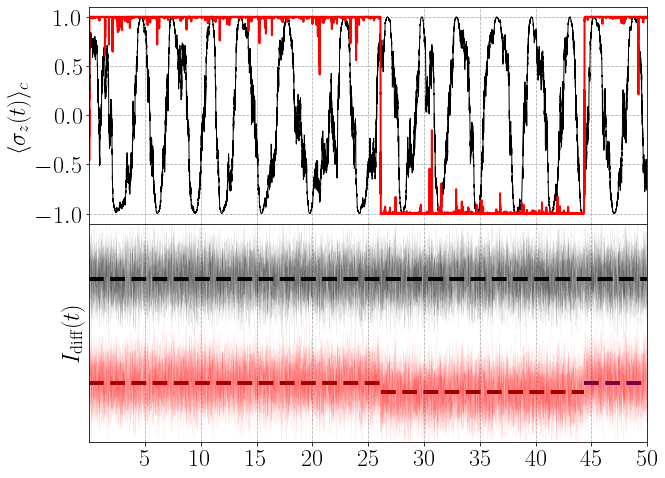

In [5]:
fig = plt.figure(figsize=(10, 8))
lw = 2
lw2 = 00.05
fs = 24
tfi = 50
t1 = 26.15
t2 = 44.3
af=0.6

plt.subplot(2, 1,1)
plt.plot(t[t<tfi], sze1[t<tfi], linewidth=1, color='k', alpha=1)
# plt.plot(t[t<tfi], np.sin(2*Ω*t[t<tfi] ))

plt.plot(t[t<tfi], sze2[t<tfi], linewidth=lw, color='r')

avg1 = np.mean(J2[t<t1]-100)
avg2 = np.mean(J2[(t1<t)&(t<t2)]-100)
avg3 = np.mean(J1[t<t1]+100)

plt.grid(True, linestyle='--')
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=fs)
plt.xticks(np.arange(5, tfi, 5), fontsize=fs)
plt.xlabel(r'$t$', fontsize=fs)
plt.ylabel(r'$\langle \sigma_{z}(t)\rangle_{c}$', fontsize=fs)

plt.xlim([0, tfi])

plt.subplot(2, 1,2)

plt.plot(t[t<tfi], J1[t<tfi]+100, linewidth=lw2, color='k', alpha=af)

plt.plot(t[t<tfi], J2[t<tfi]-100, linewidth=lw2, color='r', alpha=af)
# plt.plot(t[(t1<t)&(t<t2)], J2[(t1<t)&(t<t2)]-100, linewidth=lw2, color='r', alpha=af)
# plt.plot(t[(t2<t)&(t<tfi)], J2[(t2<t)&(t<tfi)]-100, linewidth=lw2, color='r', alpha=af)

plt.hlines(avg3, 0, tfi, color=[0.,0,0], linewidth=4, linestyle='--')

plt.hlines(avg1, 0, t1, color=[0.3,0,0], linewidth=4, linestyle='--')
plt.hlines(avg2, t1, t2, color=[0.3,0,0.0], linewidth=4, linestyle='--')
plt.hlines(avg1, t2, tfi, color=[0.0,0,0.5], linewidth=4, linestyle='--')

plt.grid(True, linestyle='--')

plt.xlim([0, tfi])
plt.ylim([-200, 200])
plt.yticks([], fontsize=fs)
plt.xticks(np.arange(5, tfi+5, 5), fontsize=fs)
plt.ylabel(r'$ I_{\rm diff}(t) $', fontsize=fs)

plt.subplots_adjust(wspace=0, hspace=0.0)

plt.show()

# fig.savefig('quantum_diffusion.png', bbox_inches='tight', dpi=300)

In [7]:
# Signal processing Fourier transform signals
yf2 = fft.fft(sze1)
xf = fft.fftfreq(len(t), dt)[:len(t)//2]


# w0 = xf[np.argmax(yf2)]*fs*dt
w0t = (Ω/(np.pi))

lfs2 = Ω
# lfs2 = 1/(2*np.pi*np.sqrt(γ1))

order1 = 1
order2 = 1
sc1 = 0.09/Ω
sc2 = 0.09/Ω
lowcut = w0t-sc1
highcut = w0t+sc2

# Pass through butterworth filter
b1, a1 = signal.butter(order1, [lowcut, highcut], 'bandpass', fs=1/dt)
b2, a2 = signal.butter(order2, lfs2, 'lowpass', fs=1/dt)

w1, h1 = signal.freqz(b1, a1, fs=1/dt, whole=False)
w2, h2 = signal.freqz(b2, a2, fs=1/dt, whole=False)

filtered1 = signal.lfilter(b1, a1, J1)
filtered2 = signal.lfilter(b2, a2, J2)


In [8]:
n = 3
fq1 = 100
fq2 = 200
W = fq2 - fq1
f0 = np.sqrt(fq1*fq2)

f0

b, a = signal.butter(n, fq1, 'low', analog=True)
# b, a = signal.cheby1(n, 0.1, fq1, 'low', analog=True)
w, h = signal.freqs(b, a)

b1, a1 = signal.butter(n, [fq1, fq2], 'bandpass', analog=True)
# b1, a1 = signal.cheby1(n, 1, [fq1, fq2], 'bandpass', analog=True)
w1, h1 = signal.freqs(b1, a1, worN=500)

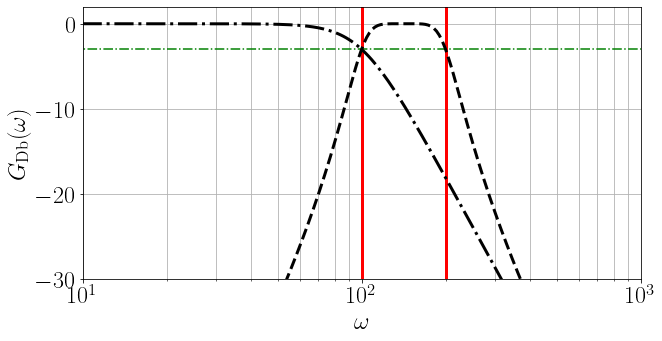

In [9]:
fig = plt.figure(figsize=(10, 5))

hlp = 1/np.sqrt(1 + (w/fq1)**(2*n))
hbp = 1/np.sqrt(1 + ((w1/(f0) - f0/(w1))*(f0/W))**(2*n))

# plt.plot(w1, 20*np.log10(np.abs(h1)), color='k', linewidth=3)
# plt.plot(w, 20*np.log10(np.abs(h)), color='k', linestyle='--', linewidth=3)

plt.plot(w, 20*np.log10(np.abs(hlp)), color='k', linestyle='-.', linewidth=3)
plt.plot(w1, 20*np.log10(np.abs(hbp)), color='k', linestyle='--', linewidth=3)

plt.vlines(fq1, 5, -200, color='r', linewidth=3)
plt.vlines(fq2, 5, -200, color='r', linewidth=3)
plt.hlines(-3, 0, 1000, color='g', linestyle='-.')

plt.ylabel(r'$G_{\rm Db}(\omega)$')
plt.xlabel(r'$\omega$')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')

plt.xscale('log')
plt.xlim([10, 1000])
plt.ylim([-30, 2])

plt.show()

# fig.savefig('gain.png', bbox_inches='tight', dpi=200)

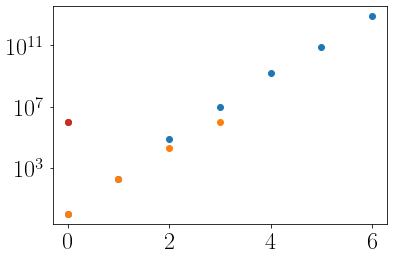

In [10]:
plt.scatter(np.arange(len(a1)), a1)
plt.scatter(np.arange(len(a)), a)

plt.scatter(np.arange(len(b1)), b1)
plt.scatter(np.arange(len(b)), b)

plt.yscale('log')

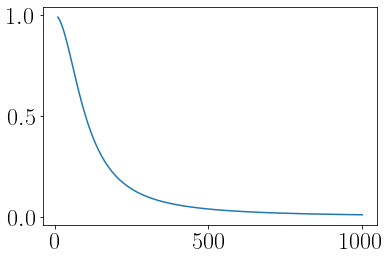

In [11]:
hlp = 1/np.sqrt(1 + (w/fq1)**(2))

plt.plot(w, hlp**2)

plt.show()

In [12]:
b1

array([1000000.,       0.,       0.,       0.])

In [13]:
sos = signal.butter(3, [10, 20], btype='bandpass', output="sos", analog=True)

z, p, k = signal.sos2zpk(sos)

# np.polyval??

np.abs(p)

array([19.20196462, 19.20196462, 14.14213562, 14.14213562, 10.4156009 ,
       10.4156009 ])

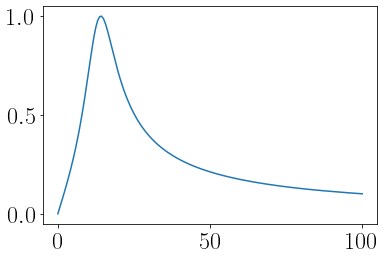

In [14]:
b, a = signal.sos2tf(sos)
b, a = signal.butter(1, [10, 20], btype='bandpass', analog=True)

# b, a = signal.sos2tf(sos)
w, h = signal.freqs(b, a)

# H1 = np.sum(np.array([b[ix] * w**(-ix) for ix in range(len(b))]), axis=0)/ np.sum(np.array([a[i] * w**(-i) for i in range(len(a))]), axis=0)

plt.plot(w, np.abs(h))
plt.show()

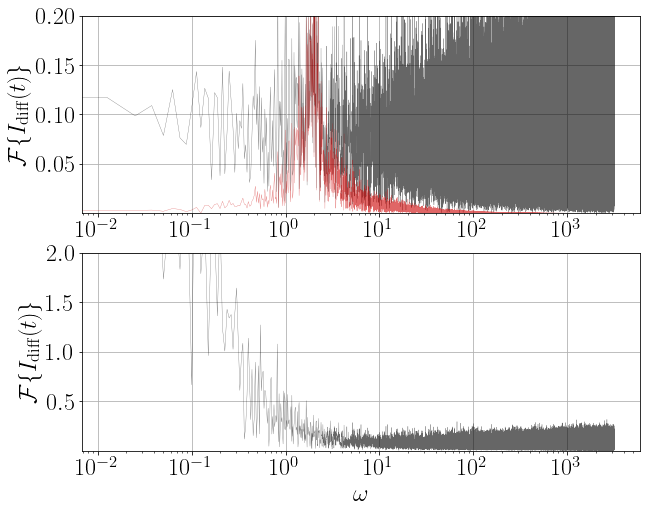

In [15]:
y1 = fft.fft(J1)
yf1 = fft.fft(filtered1)

y2 = fft.fft(J2)
yf2 = fft.fft(filtered2)
xf = fft.fftfreq(len(t), dt)[:len(t)//2]*2*np.pi

fig = plt.figure(figsize=(10, 8))

plt.subplot(2,1,1)
plt.plot(xf, 2/len(t) * np.abs(y1[0:len(t)//2]), linewidth=0.3, color=[0.0,0,0], alpha=0.6)
plt.plot(xf, 2/len(t) * np.abs(yf1[0:len(t)//2]), linewidth=0.3, color=[0.8,0,0], alpha=0.6)

# plt.vlines(2*Ω, 0, 3, color='b', linewidth=2, linestyle='-')
# plt.vlines(2*lowcut*np.pi, 0, 3, color='b', linewidth=2, linestyle='--')
# plt.vlines(2*highcut*np.pi, 0, 3, color='b', linewidth=2, linestyle='--')

plt.ylim([10e-7,0.2])
# plt.xlim([0.1, 4])
plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\mathcal{F}\{I_{\rm diff}(t)\}$', fontsize=fs)
plt.xlabel(r'$\omega$', fontsize=fs)
plt.grid()

plt.subplot(2,1,2)
plt.plot(xf, 2/len(t) * np.abs(y2[0:len(t)//2]), linewidth=0.3, color=[0.0,0,0], alpha=0.6)
# plt.plot(xf, 2/len(t) * np.abs(yf2[0:len(t)//2]), linewidth=0.3, color=[0.8,0,0], alpha=0.6)

# plt.vlines(2*Ω, 0, 3, color='b', linewidth=3, linestyle='--')
# plt.vlines(2*lowcut*np.pi, 0, 3, color='b', linewidth=3, linestyle='--')
# plt.vlines(2*highcut*np.pi, 0, 3, color='b', linewidth=3, linestyle='--')

plt.ylim([10e-7,2])
# plt.xlim([0.1, 4])
plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.ylabel(r'$\mathcal{F}\{I_{\rm diff}(t)\}$', fontsize=fs)
plt.xlabel(r'$\omega$', fontsize=fs)

plt.grid()
plt.show()

# fig.savefig('spectrum.png', bbox_inches='tight', dpi=300)

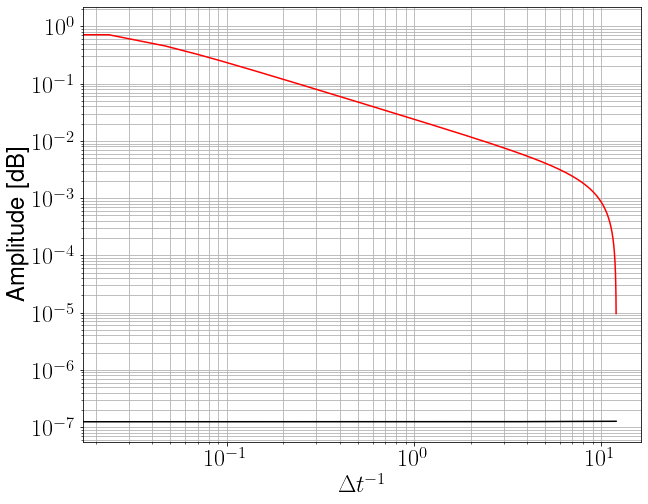

In [16]:
w1, h1 = signal.freqz(b1, a1, fs=fs, worN=512)
w2, h2 = signal.freqz(b2, a2, fs=fs, worN=512)


fig = plt.figure(figsize=(10, 8))
plt.plot(w1, np.abs(h1), color='k')
plt.plot(w2, np.abs(h2), color='r')

plt.xlabel(r'$\Delta t^{-1}$', fontsize=fs)
plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.yscale('log')
plt.xscale('log')


plt.show()

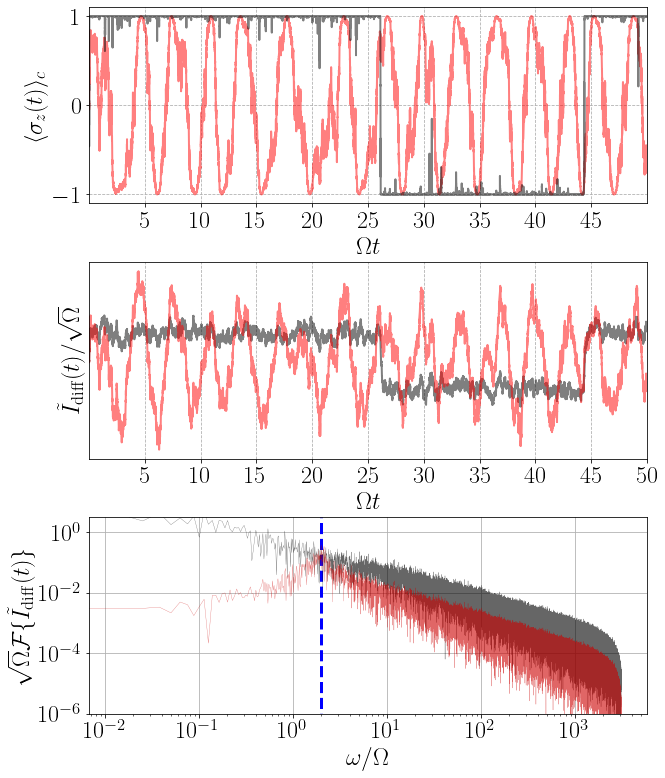

In [27]:
fig = plt.figure(figsize=(10, 13))

lw = 2

# subplot 1
plt.subplot(3,1,1)
plt.plot(t[t<tfi], sze1[t<tfi], linewidth=lw, color='r', alpha=0.5)
plt.plot(t[t<tfi], sze2[t<tfi], linewidth=lw, color='k', alpha=0.5)
# plt.plot(t[t<tfi], filtered1[t<tfi]/(np.sqrt(2*γ1)), linewidth=lw, color='k', alpha=0.5)

plt.yticks([-2, -1, 0, 1, 2])
plt.xticks(np.arange(5, tfi, 5))
plt.tick_params(axis='both', which='major', labelsize=fs)
plt.ylim([-1.1,1.1])
plt.grid(True, linestyle='--')
plt.ylabel(r'$\langle \sigma_{z}(t)\rangle_{c}$', fontsize=fs)
plt.xlabel(r'$ \Omega t $', fontsize=fs)

plt.xticks(np.arange(5, tfi, 5), fontsize=fs)
plt.xlim([0, tfi])


plt.subplot(3, 1, 2)

plt.plot(t[t<tfi], filtered2[t<tfi]/(2*np.sqrt(γ2)), linewidth=lw, color='k', alpha=0.5)
plt.plot(t[t<tfi], filtered1[t<tfi]/(2*np.sqrt(γ1)), linewidth=lw, color='r', alpha=0.5)

# plt.plot(t[t<tfi], sze2[t<tfi] + np.random.normal(0, 0.5/np.sqrt(γ2),len(t[t<tfi])) , linewidth=lw, color='k', alpha=0.5)
# plt.plot(t[t<tfi], sze1[t<tfi]+ np.random.normal(0, 0.5/np.sqrt(γ1),len(t[t<tfi])), linewidth=lw, color='r', alpha=0.5)

plt.grid(True, linestyle='--')
plt.xlim([0, tfi])
plt.yticks([], fontsize=fs)
plt.xticks(np.arange(5, tfi+5, 5), fontsize=fs)
plt.ylabel(r'$ \tilde{I}_{\rm diff}(t)/\sqrt{\Omega} $', fontsize=fs)
plt.xlabel(r'$ \Omega t $', fontsize=fs)


plt.subplot(3, 1, 3)

plt.plot(xf, 2/len(t) * np.abs(yf2[0:len(t)//2]), linewidth=0.3, color=[0.0,0,0], alpha=0.6)
plt.plot(xf, 2/len(t) * np.abs(yf1[0:len(t)//2]), linewidth=0.3, color=[0.8,0,0], alpha=0.6)

plt.vlines(2*Ω, 0, 3, color='b', linewidth=3, linestyle='--')

plt.ylim([10e-7,3])
# plt.xlim([0.1, 6])

plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.ylabel(r'$\sqrt{\Omega}\mathcal{F}\{\tilde{I}_{\rm diff}(t)\} $', fontsize=fs)
plt.xlabel(r'$\omega/\Omega$', fontsize=fs)

plt.grid()

plt.subplots_adjust(wspace=0, hspace=0.3)

plt.show()

fig.savefig('quantum_diffusion_filtered.png', bbox_inches='tight', dpi=150)

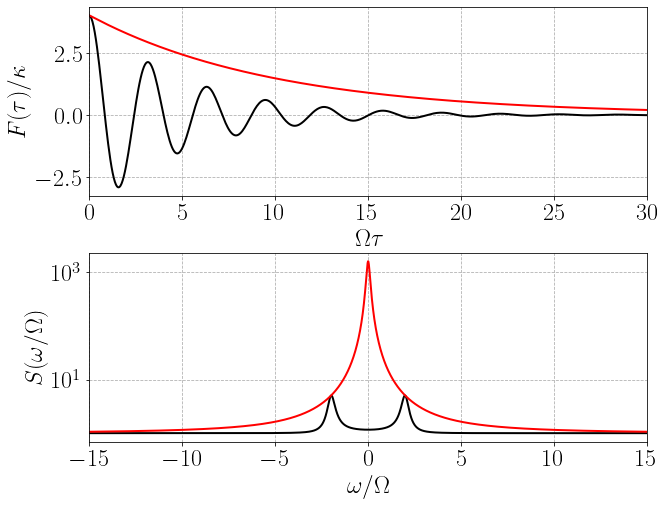

In [24]:
fig = plt.figure(figsize=(10, 8))

lw = 2
plt.subplot(2, 1,1)
plt.plot(τ, (Ft1)/γ1, linewidth=lw, color='k')
plt.plot(τ, (Ft2)/γ2, linewidth=lw, color='r')

plt.yticks(fontsize=fs)
plt.xticks(np.arange(0, 35, 5),fontsize=fs)

plt.xlabel(r'$\Omega \tau$', fontsize=fs)
plt.ylabel(r'$F(\tau)/\kappa $', fontsize=fs)
plt.grid(True, linestyle='--')
plt.xlim([0, τ[-1]])

plt.subplot(2, 1,2)
plt.plot(ω, (Sω1), linewidth=lw, color='k')
plt.plot(ω, (Sω2), linewidth=lw, color='r')
# plt.vlines(Ω, 0, 10e3)

plt.yticks(fontsize=fs)
plt.xticks(fontsize=fs)
plt.yscale('log')

plt.xlabel(r'$\omega/\Omega$', fontsize=fs)
plt.ylabel(r'$S(\omega/\Omega) $', fontsize=fs)
plt.grid(True, linestyle='--')
plt.yscale('log')
plt.xlim([-ω0, ω0])


plt.subplots_adjust(wspace=0, hspace=0.3)

plt.show()
fig.savefig('quantum_diffusion_power.png', bbox_inches='tight', dpi=200)

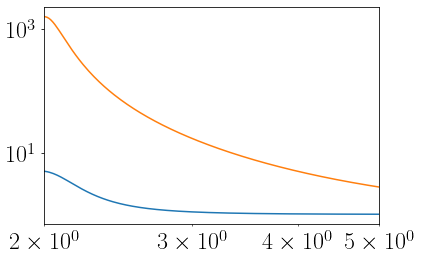

In [241]:
plt.plot(ω[ω>0], Sω1[ω>0])
plt.plot(ω[ω>0]+2, Sω2[ω>0])

# plt.plot(ω[ω>0], 1/ω[ω>0]**5 + 10)

plt.xscale('log')
plt.yscale('log')

plt.xlim([2,5])

plt.show()

# Make plot of D scaling

In [8]:
klist = np.linspace(0.01, 20, 1000)
Dlist = np.zeros(len(klist))

for i, k in enumerate(klist):
    c2 = np.sqrt(k)*sigmaz()
    
    ρ0 = steadystate(H, [c2])
    
    
    Dlist[i] = FCSPowerSpectrumLinear(H, [c2], ρ0, [0.001], [c2], [1], method='Homodyne')

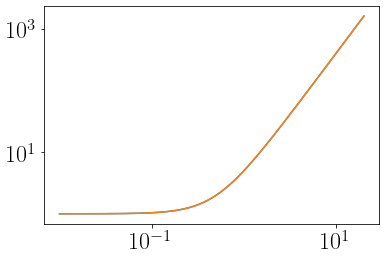

In [9]:
plt.plot(klist, Dlist)

plt.plot(klist, 1 + 4*klist**2)

plt.yscale('log')
plt.xscale('log')

plt.show()

In [12]:
# γ1 = 0.2
γ2 = 0.2
Ω = 1

sx = sigmax()
sy = sigmay()
sz = sigmaz()
H = Ω*sx
c = np.sqrt(γ2)*sigmaz()

ρ0 = steadystate(H, [c])

tf = 50
dt = 0.002;
t = np.arange(0, tf, dt)
ntraj = 1000

result1 = smesolve(H, ρ0, t, sc_ops=[c], e_ops=[sz], store_measurement=True, ntraj=ntraj)


10.0%. Run time:  26.37s. Est. time left: 00:00:03:57
20.0%. Run time:  52.86s. Est. time left: 00:00:03:31
30.0%. Run time:  79.45s. Est. time left: 00:00:03:05
40.0%. Run time: 105.87s. Est. time left: 00:00:02:38
50.0%. Run time: 132.27s. Est. time left: 00:00:02:12
60.0%. Run time: 158.67s. Est. time left: 00:00:01:45
70.0%. Run time: 185.35s. Est. time left: 00:00:01:19
80.0%. Run time: 212.02s. Est. time left: 00:00:00:53
90.0%. Run time: 238.38s. Est. time left: 00:00:00:26
Total run time: 264.95s


In [13]:
Nt = np.array([np.real(np.cumsum(result1.measurement[i].T[0])*dt) for i in range(ntraj)])

D = FCSPowerSpectrumLinear(H, [c], ρ0, [0.001], [c], [1], method='Homodyne')[0]

Jvals = np.linspace(-D*tf, D*tf, 200)
dist = np.exp(-Jvals**2 / (2*D*tf)) * (1/np.sqrt(2*np.pi*D*tf))



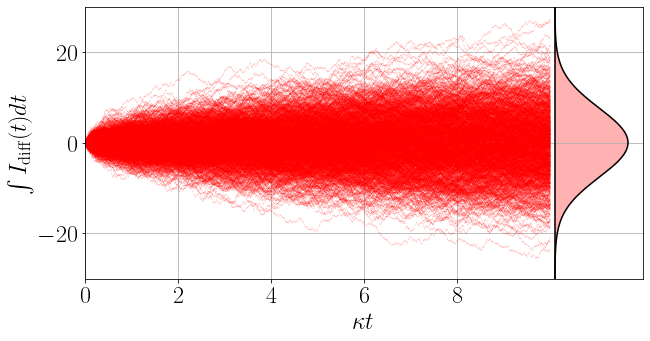

In [16]:
fig = plt.figure(figsize=(10, 5))

dd = 30
yf = 30
ff = 0.5
fs = 24

# plt.subplot(2, 1, 1)

plt.plot(γ2*t, Nt.T, color='r', linewidth=0.05)

plt.plot(dd*dist+γ2*(tf+ff), Jvals, color='k')
plt.vlines(γ2*(tf+ff), -30, 30, color='k')

plt.fill_betweenx(Jvals, dd*dist+γ2*(tf+ff), γ2*(tf+ff), color='r', alpha=0.3)

plt.xlim([0, 10+2])
plt.ylim([-yf, yf])
plt.grid()
plt.xticks(np.arange(0, 10, 2), fontsize=fs)
plt.yticks( fontsize=fs)

plt.xlabel(r'$\kappa t$', fontsize=fs)
plt.ylabel(r'$\int I_{\rm diff}(t) dt$', fontsize=fs)

# plt.subplot(2, 1, 2)

# plt.plot(klist, Dlist, color='b', linewidth=3)

# plt.yscale('log')
# plt.xscale('log')
# plt.grid()
# plt.yticks( fontsize=fs)
# plt.xticks( fontsize=fs)

# plt.subplots_adjust(wspace=0, hspace=0.3)

# plt.xlabel(r'$\kappa$', fontsize=fs)
# plt.ylabel(r'$\mathcal{D}$', fontsize=fs)

plt.show()

# fig.savefig('quantum_diffusion_D.png', bbox_inches='tight', dpi=300)

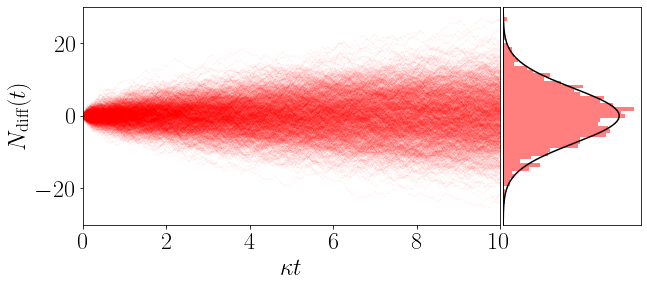

In [23]:
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
ax1.plot(γ2*t, Nt.T, color='r', linewidth=0.01)
ax1.set_xlim([0, 10])
ax1.set_ylim([-dd, dd])
ax1.set_xlabel(r'$\kappa t$')
ax1.set_ylabel(r'$N_{\rm diff}(t)$')

ax2 = plt.subplot2grid((1, 4), (0, 3), colspan=1)
ax2.hist(Nt[:, -1], bins=50, density=True, orientation='horizontal', color='r', alpha=0.5)
ax2.plot(dist, Jvals, color='k')
ax2.vlines(0, -30, 30, color='k')
ax2.set_ylim([-dd, dd])

ax2.set_yticks([])
ax2.set_xticks([])


# # ax3 = plt.subplot2grid((2, 4), (1, 0), colspan=4)
# ax3.plot(klist, Dlist, color='b', linewidth=3)
# ax3.set_yscale('log')
# ax3.set_xscale('log')
# ax3.grid()
# ax3.set_xlabel(r'$\kappa$', fontsize=fs)
# ax3.set_ylabel(r'$D$', fontsize=fs)
# ax3.set_yticks([1, 10, 100, 1000])

plt.subplots_adjust(wspace=0.02, hspace=0.3)

plt.show()
fig.savefig('quantum_diffusion_D.png', bbox_inches='tight', dpi=100)

In [182]:
 γ1 = 1
Ω = 1

sx = sigmax()
sy = sigmay()
sz = sigmaz()
H = Ω*sx
c = np.sqrt(γ2)*sigmaz()

ρ0 = 

tf = 10
dt = 0.01;
t = np.arange(0, tf, dt)
# ntraj =5000

result = smesolve(H, ρ0, t, sc_ops=[c], e_ops=[sz], store_measurement=True, ntraj=1)


Total run time:   0.01s


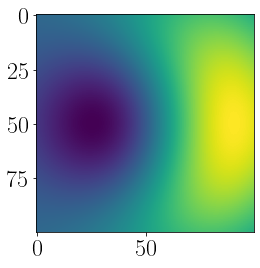

In [190]:
ψ0 = (fock(2,0) + fock(2, 1))/np.sqrt(2)

X = np.linspace(-1, 1, 100)

XX, YY = np.meshgrid(X, X)

w = wigner(ψ0, X, X)

plt.imshow(w)

In [191]:
r, θ XX

array([[-1.        , -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       [-1.        , -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       [-1.        , -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       ...,
       [-1.        , -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       [-1.        , -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ],
       [-1.        , -0.97979798, -0.95959596, ...,  0.95959596,
         0.97979798,  1.        ]])